# Create Video

This notebook is used to create a UNET with a Resnet18 as a backbone with the fastai library. 

In [1]:
import os
import cv2

from natsort import natsorted
import numpy as np

from PIL import Image

from fastcore.xtras import Path

from fastai.data.block import DataBlock
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.losses import CrossEntropyLossFlat

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.all import Learner
from fastai.vision.all import L
from fastai.vision.all import params

#### Define some paths for later use.

In [2]:
repo_path = os.path.dirname(os.path.abspath(''))
data_path = os.path.join(repo_path, 'data')
src_path = os.path.join(repo_path, 'src')
path_im = os.path.join(data_path, 'Images')

#### Get the path including the filename of alls images

In [3]:
fnames = get_image_files(path_im)

#### Randomly select 20% of the images as validation images and 20% as test images
Furthermore the names of the valisation images get saved to the valid.txt file so that the DataBlock can split the data

In [4]:
fnames_array = np.array(fnames)

np.random.seed(5)
np.random.shuffle(fnames_array)

train_fnames, valid_fnames, test_fnames = np.split(fnames_array, [int(0.6*len(fnames_array)), int(0.8*len(fnames_array))])

train_val_fnames = np.concatenate((train_fnames, valid_fnames))

valid_fnames = [str(abs_path).split('/')[-1] for abs_path in valid_fnames]
np.savetxt(os.path.join(data_path, 'valid.txt'), valid_fnames, fmt='%s')


#### Define a function that will supply the DataBlock with the imagenames 

In [5]:
def get_train_files(path_im):
    train_data = list()
    for i in train_val_fnames:
        train_data.append(Path(i))
    return train_data   

#### Define a lambda function to get the path to a mask for a given image

In [6]:
get_msk = lambda o: str(o.absolute()).replace('Images', 'Labels_int')

#### Define a list containing the color values of the different classes in the masks and an array containing the names of the different classes

In [7]:
VOC_COLORMAP = [
    [0, 220, 220], [70, 70, 70], [153, 153, 190], [160, 170, 250],
    [60, 20, 220], [153, 153, 153], [50, 234, 157], [128, 64, 128],
    [232, 35, 244], [35, 142, 107], [142, 0, 0], [156, 102, 102], [0, 0, 0]
]

VOC_CLASSES = np.array([
    'Traffic Sign', 'Building', 'Fence', 'Other', 'Pedestrian', 'Pole', 'Road Line',
    'Road', 'Sidewalk', 'Vegetation', 'Car', 'Wall', 'Unlabeled'
])

#### Define a function that splits the dataset into training and validation data

In [8]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

#### Use the DataBlock of the fastai API to get the data into a dataloader

In [9]:
david = DataBlock(blocks=(ImageBlock, MaskBlock(VOC_CLASSES)),
                 get_items=get_train_files,
                 splitter=FileSplitter(os.path.join(data_path, 'valid.txt')),
                 get_y=get_msk,
                 batch_tfms=[*aug_transforms(size=(608,800)), Normalize.from_stats(*imagenet_stats)])

#### Get the dataloaders 

In [10]:
dls = david.dataloaders(os.path.join(data_path, 'Images'), bs=1)

#### Custom splitter to apply Discriminative learning

In [11]:
def unet_splitter(m): return L(m.encoder,m.decoder).map(params)

#### Create weights for a weighted loss func



In [12]:
WEIGHTED_LOSS_FUNC = False

loss_func = CrossEntropyLossFlat(axis=1)

#### Define a accuracy metric

In [13]:
void_code = 12

def acc_david(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

#### Training our Unet

In [14]:
from model_architecture import Unet

learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet18',n_out=13),loss_func=loss_func, metrics=acc_david, splitter=unet_splitter)

learn.summary()


13


Unet (Input shape: 1 x 3 x 608 x 800)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 64 x 304 x 400  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     1 x 64 x 152 x 200  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                             

#### Save and/or load the model

In [15]:
if WEIGHTED_LOSS_FUNC:
    learn.load(os.path.join(src_path, 'models', 'timm_resnet18_unet_weighted-loss'), with_opt=False, device='cuda')
else:
    learn.load(os.path.join(src_path, 'models', 'timm_resnet18_unet'), with_opt=False, device='cuda')

## Let's create a video with the trained model

#### Define prediction function

In [16]:
def predict_on_batch(dl):
    preds, _ = learn.get_preds(dl=dl)
    if preds.shape[2] == 608:
        correct_size_preds = preds[:,:,4:-4,:]
    else:
        correct_size_preds = preds
    return correct_size_preds

#### Get images from the test_dl

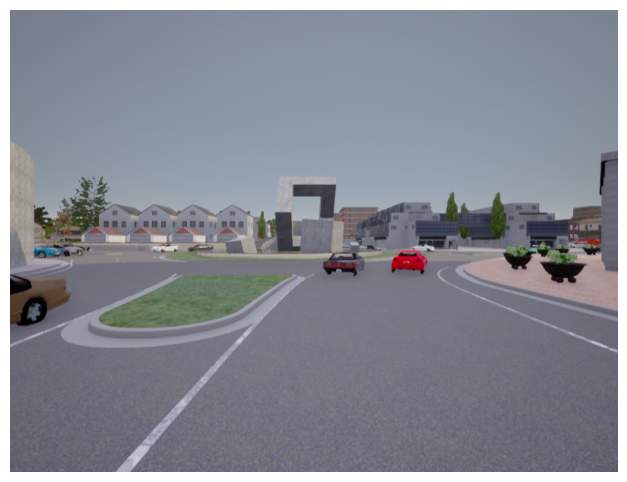

In [17]:
video_fnames = get_image_files(os.path.join(data_path, 'Test', 'Images'))
video_fnames = np.sort(video_fnames)
video_fnames_batches = np.array_split(video_fnames, 100)

dl = learn.dls.test_dl(video_fnames)
dl.show_batch(figsize=(12,6))

#### Predict on the images and save the predictions in a list

In [ ]:
from IPython.utils import io
from tqdm import tqdm

video_preds = list()

with tqdm(total=len(video_fnames_batches)) as pbar:
    for batch in video_fnames_batches:
        pbar.update(1)
        dl = learn.dls.test_dl(batch)
        with io.capture_output() as captured:
            preds = predict_on_batch(dl=dl)
        video_preds.append(preds)

#### Transform predictions into RGB images and save them

In [ ]:
image_dir = os.path.join(data_path, 'Test/Preds')

index = 0
for list in video_preds:
    for pred in list:
        pred_argmax = np.array((pred).argmax(dim=0)).astype(np.int8)
        output_array = np.zeros((3,600,800))
        for i in range(600):
            for j in range(800):
                color = VOC_COLORMAP[pred_argmax[i,j]]
                output_array[:,i,j] = color
        image = Image.fromarray(output_array.transpose(1,2,0).astype(np.uint8))
        filename = str(index) + '.png'
        image.save(os.path.join(image_dir, filename))
        index += 1

#### Iterate over all predicted images and create a video
The video is an overlay of the original raw image and the predicted class labels

In [ ]:
video_path = '/home/ujrgt/lama/itw_lama_group8/data/Test'
images_path = os.path.join(data_path, 'Test/Images/Video_027')

if WEIGHTED_LOSS_FUNC:
    video_file = os.path.join(video_path, 'output_video_weighted.mp4')
else:
    video_file = os.path.join(video_path, 'output_video.mp4')

image_files = natsorted([os.path.join(image_dir,f) for f in os.listdir(image_dir) if f.endswith('.png')])
raw_image_files = natsorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.png')])

image = cv2.imread(image_files[0])
height, width, _ = image.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_file, fourcc, 10, (width, height))

for i in range(len(image_files)):
    image1 = cv2.imread(image_files[i])
    image2 = cv2.imread(raw_image_files[i])
    image = cv2.addWeighted(image2, .6, image1, 1, 0)
    video_writer.write(image)

video_writer.release()